# Phase 3: Microservice Identification (Grouping by Similar Services)

In [33]:
version = "v_team" # All options: v_imen, v_team
system = "petclinic" # All options: jforum, cargotracker, petclinic, pos
model_type = "codebert" # All options: ft_codebert, word2vec, albert, codebert, roberta, bert
best_community_detection_algorithm = 'Louvain' # All options: Louvain, EdMot, Infomap, LabelPropagation, FastGreedy, GirvanNewman

In [34]:
import pandas as pd
import numpy as np
from utils import save_microservices_to_file
import networkx as nx
import skfuzzy as fuzz
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from graphs import remove_zero_weight_edges, print_graph, construct_dissimilarity_matrix
from optimization import detect_elbow
from cluster_analysis import assign_clusters_based_on_comparative_ratios, merge_overlapping_clusters, identify_standalone_services
from normalization import normalize_data, normalize_memberships
from distances import compute_static_distances_for_service_pairs, compute_semantic_distances_for_service_pairs

## 1.1 Create service graph

In [35]:
# Global variable for filename
filename = f"generated_data/graph/service/{version}_{system}_service_graph.csv"

# Load the data from CSV files
communities_df = pd.read_csv(f"generated_data/phase2_service_clustering/{version}_{system}_{best_community_detection_algorithm}_communities.csv")
class_graph_df = pd.read_csv(f"generated_data/graph/class/{version}_{system}_class_graph.csv")
embeddings_df = pd.read_csv(f"generated_data/embedding/{version}_{system}_{model_type}_embeddings.csv")

# Extract class names and their embeddings from the embeddings DataFrame
class_names = embeddings_df.iloc[:, 0].str.split(';', expand=True)[0]
embeddings = embeddings_df.iloc[:, 1:].values
class_embeddings_dict = dict(zip(class_names, embeddings))

In [36]:
# Compute static and semantic distances between service pairs
static_distances = compute_static_distances_for_service_pairs(class_graph_df, communities_df)
semantic_distances = compute_semantic_distances_for_service_pairs(class_embeddings_dict, communities_df)

# Normalize the distances between 0 and 1
normalized_static_distances = normalize_data(static_distances)
normalized_semantic_distances = normalize_data(semantic_distances)

# Create the service graph DataFrame
service_graph_data = [
    [s1, s2, normalized_static_distances.get((s1, s2), 0), normalized_semantic_distances.get((s1, s2), 0)]
    for s1, s2 in static_distances.keys()
]
service_graph_df = pd.DataFrame(service_graph_data, columns=['service1', 'service2', 'static_distance', 'semantic_distance'])

# Save the service graph DataFrame to a CSV file
service_graph_df.to_csv(filename, index=False)

## 1.2 Cluster services

In [37]:
def compute_edge_weight(semantic, static, alpha=0.5):
    """
    Compute the edge weight based on semantic and static similarity.

    Parameters:
        semantic (float): The semantic similarity value between two services.
        static (float): The static similarity value between two services.
        alpha (float): The weight given to the static similarity.

    Returns:
        float: The computed edge weight.
    """
    if not (0 <= semantic <= 1) or not (0 <= static <= 1):
        raise ValueError("Both 'semantic' and 'static' values should be between 0 and 1.")
    
    beta = 1 - alpha
    return alpha * static + beta * semantic

In [38]:
service_graph_df = pd.read_csv(filename)

services_graph = nx.DiGraph([
    (row['service1'], row['service2'], {"weight": compute_edge_weight(row['semantic_distance'], row['static_distance'], alpha=1.0)}) # adjust alpha here
    for _, row in service_graph_df.iterrows()
])

remove_zero_weight_edges(services_graph)
print_graph(services_graph)
nodes_list = list(services_graph.nodes)

# Construct the dissimilarity matrix
dissimilarity_matrix = construct_dissimilarity_matrix(services_graph)

Application Service 1 -> Entity Service 3: 0.0789473684210526
Application Service 1 -> Entity Service 5: 0.0789473684210526
Application Service 2 -> Entity Service 4: 0.0526315789473684
Application Service 3 -> Entity Service 2: 0.1052631578947368
Application Service 3 -> Entity Service 4: 0.131578947368421
Application Service 4 -> Entity Service 1: 0.1578947368421052
Application Service 4 -> Entity Service 2: 0.1578947368421052
Application Service 4 -> Entity Service 4: 0.1052631578947368
Application Service 5 -> Entity Service 1: 0.0263157894736842
Entity Service 1 -> Entity Service 2: 1.0
Entity Service 2 -> Entity Service 1: 0.0526315789473684
Entity Service 3 -> Entity Service 1: 0.5
Entity Service 3 -> Entity Service 2: 0.5
Utility Service 2 -> Entity Service 1: 0.0263157894736842
Utility Service 2 -> Entity Service 4: 0.0263157894736842


### 1.2.1 Fuzzy C-means from Scikit

In [39]:
# Constants
FUZZINESS = 2
ERROR_THRESHOLD = 0.005
MAX_ITERATIONS = 1000
CLUSTER_RANGE = range(2, 100)

def determine_optimal_clusters(data):
    """Determines the optimal number of clusters using the Elbow method."""
    fpc_values = []
    for c_value in CLUSTER_RANGE:
        _, _, _, _, _, _, fpc = fuzz.cmeans(
            data.T, 
            c=c_value, 
            m=FUZZINESS, 
            error=ERROR_THRESHOLD, 
            maxiter=MAX_ITERATIONS
        )
        fpc_values.append(fpc)

    plt.figure()
    plt.plot(CLUSTER_RANGE, fpc_values)
    plt.title('Fuzzy Partition Coefficient (FPC) for different cluster numbers')
    plt.xlabel('Number of clusters')
    plt.ylabel('FPC')
    plt.grid(True)
    plt.show()

    return detect_elbow(fpc_values)

def fuzzy_cmeans_clustering(data, node_labels, optimal_clusters):
    """
    Clusters the data using Fuzzy C-Means, returning only significant memberships.
    
    Parameters:
        data: 2D array of shape (features, samples), the input data.
        node_labels: List of labels corresponding to the samples.
        optimal_clusters: The number of clusters to form as well as the number of centroids to generate.
        membership_threshold: Threshold for membership values to determine significant cluster membership.
        
    Returns:
        dict: A dictionary with node labels as keys and lists of (cluster, membership) tuples as values.
    """
    cntr, u, _, _, _, _, _ = fuzz.cmeans(
        data.T,
        c=optimal_clusters,
        m=FUZZINESS,
        error=ERROR_THRESHOLD,
        maxiter=MAX_ITERATIONS
    )
    
    # Create a dictionary to store memberships for each node
    memberships = {label: [] for label in node_labels}
    for i, label in enumerate(node_labels):
        memberships[label] = [(f'cluster{j+1}', u[j, i]) for j in range(optimal_clusters)]

    return memberships

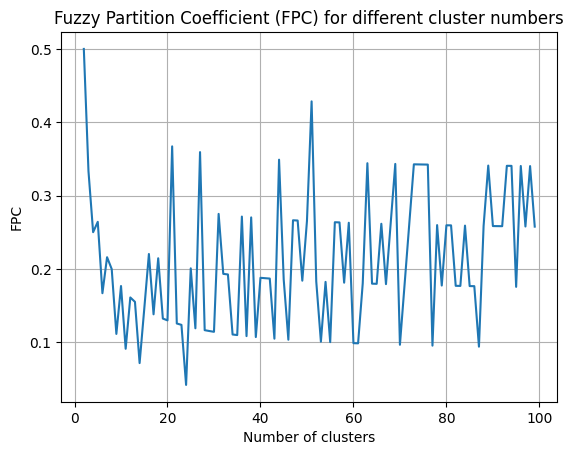

Optimal number of clusters: 22


In [40]:
optimal_clusters = determine_optimal_clusters(dissimilarity_matrix)
print(f"Optimal number of clusters: {optimal_clusters}")

In [41]:
memberships = fuzzy_cmeans_clustering(dissimilarity_matrix, nodes_list, optimal_clusters)
normalized_memberships = normalize_memberships(memberships)
fuzzy_memberships = assign_clusters_based_on_comparative_ratios(normalized_memberships)

for node, memberships in fuzzy_memberships.items():
        print(f"{node}: {', '.join(f'{cluster} ({membership:.2f})' for cluster, membership in memberships)}")

save_microservices_to_file(fuzzy_memberships, communities_df, 
                           f"generated_data/phase3_microservice_clustering/cmeans/{version}_{system}_{best_community_detection_algorithm}_microservices.txt")

Application Service 1: cluster12 (0.05), cluster21 (0.05), cluster8 (0.05), cluster10 (0.05), cluster18 (0.05), cluster15 (0.05), cluster20 (0.05), cluster5 (0.05), cluster6 (0.05), cluster3 (0.05), cluster2 (0.05), cluster16 (0.05), cluster13 (0.05), cluster4 (0.05), cluster1 (0.05), cluster9 (0.05), cluster11 (0.05), cluster19 (0.05), cluster17 (0.05), cluster22 (0.05), cluster7 (0.05), cluster14 (0.02)
Application Service 2: cluster8 (0.05), cluster12 (0.05), cluster10 (0.05), cluster21 (0.05), cluster18 (0.05), cluster5 (0.05), cluster20 (0.05), cluster3 (0.05), cluster6 (0.05), cluster15 (0.05), cluster2 (0.05), cluster16 (0.05), cluster13 (0.05), cluster4 (0.05), cluster1 (0.05), cluster9 (0.05), cluster11 (0.05), cluster19 (0.05), cluster17 (0.05), cluster22 (0.05), cluster7 (0.05), cluster14 (0.02)
Application Service 3: cluster8 (0.05), cluster10 (0.05), cluster12 (0.05), cluster21 (0.05), cluster18 (0.05), cluster5 (0.05), cluster3 (0.05), cluster20 (0.05), cluster6 (0.05), c

### 1.2.1 Custom fuzzy C-means

In [42]:
class CustomFuzzyCMeans:
    """
    A custom implementation of the Fuzzy C-Means clustering algorithm.

    Attributes:
        center_type_indices: A dict mapping the service type to its index.
    """
    def __init__(self):
        self.center_type = 'Application'
        self.center_type_indices = {}

    def calculate_membership(self, service_idx, center_idx, distances):
        """
        Calculate the fuzzy membership of a service to a cluster center.
        
        Parameters:
        service_idx (int): Index of the service for which membership is being calculated.
        center_idx (int): Index of the cluster center to which membership is being calculated.
        distances (list): Matrix of distances between services and cluster centers.
        
        Returns:
        float: The membership value of the service to the cluster center.
        """
        epsilon = 1e-10  # Small value to avoid division by zero.
        distance_to_center = distances[service_idx][center_idx]

        membership_sum = 0.0

        if distance_to_center == 0:
            return 1.0
        
        for other_center_idx in self.center_type_indices.values():
            if other_center_idx != service_idx:
                # Direct distances to other centers
                other_distance_to_center = distances[service_idx][other_center_idx]

                membership_ratio = distance_to_center / (other_distance_to_center + epsilon)
                membership_sum += membership_ratio ** 2

        # The membership value is the inverse of the sum, normalized by the number of centers
        return 1 / membership_sum if membership_sum > 0 else 0

        
    def cluster_services(self, services_list, distances):
        """
        Cluster services based on their membership values to each cluster center.

        Parameters:
        services_list (list): List of all services to be clustered.
        distances (list): Matrix of distances between services and cluster centers.

        Returns:
        dict: A dictionary with services as keys and lists of (cluster, membership) tuples as values.
        """

        self.center_type_indices = {
            service: idx for idx, service in enumerate(nodes_list) if service.startswith(self.center_type)
        }
        
        # Calculate raw membership values for each service to each cluster center
        memberships = {}
        for service_idx, service in enumerate(services_list):
            service_memberships = []
            for idx, (_, center_idx) in enumerate(self.center_type_indices.items()):
                membership_value = self.calculate_membership(service_idx, center_idx, distances)
                service_memberships.append((f"cluster{idx+1}", membership_value))
            memberships[service] = service_memberships

        return memberships

In [43]:
memberships = CustomFuzzyCMeans().cluster_services(nodes_list, dissimilarity_matrix)
normalized_memberships = normalize_memberships(memberships)
fuzzy_memberships = assign_clusters_based_on_comparative_ratios(normalized_memberships)

# Call the method to merge clusters with overlap above merge_threshold
fuzzy_memberships = identify_standalone_services(fuzzy_memberships)
fuzzy_memberships = merge_overlapping_clusters(fuzzy_memberships, overlap_threshold=0.3)

for node, memberships in fuzzy_memberships.items():
        print(f"{node}: {', '.join(f'{cluster} ({membership:.2f})' for cluster, membership in memberships)}")
        
save_microservices_to_file(fuzzy_memberships, communities_df, 
                           f"generated_data/phase3_microservice_clustering/custom_cmeans/{version}_{system}_{best_community_detection_algorithm}_microservices.txt")

Standalone candidates: set()
Overlapping clusters: {(1, 2), (3, 4)}
Application Service 1: cluster1 (0.50)
Application Service 2: cluster1 (0.50)
Application Service 3: cluster2 (0.50)
Application Service 4: cluster2 (0.50)
Application Service 5: cluster3 (0.50)
Entity Service 1: cluster2 (0.26)
Entity Service 2: cluster2 (0.25)
Entity Service 3: cluster1 (0.23)
Entity Service 4: cluster2 (0.23)
Entity Service 5: cluster1 (0.23)
Utility Service 1: cluster1 (0.20)
Utility Service 2: cluster1 (0.20)


### 1.2.2 Hierarchical clustering

In [44]:
def perform_clustering(dissimilarity_matrix, max_d):
    Z = linkage(squareform(dissimilarity_matrix), method='average')
    clusters = fcluster(Z, max_d, criterion='distance')
    return clusters

def calculate_wcss(clusters, dissimilarity_matrix):
    wcss = 0
    for i in np.unique(clusters):
        cluster_points = dissimilarity_matrix[clusters == i]
        centroid = np.mean(cluster_points, axis=0)
        wcss += np.sum((cluster_points - centroid) ** 2)
    return wcss

def hierarchical_clustering(dissimilarity_matrix, nodes, max_d):
    """
    Perform hierarchical clustering and return fuzzy memberships.

    Parameters:
    - dissimilarity_matrix: The matrix of dissimilarity between nodes.
    - nodes: The list of node labels.
    - max_d: The threshold to cut the dendrogram to form clusters.

    Returns:
    - A dictionary with node labels as keys and a list of (cluster, membership) tuples as values.
    """
    # Perform the hierarchical clustering
    clusters = perform_clustering(dissimilarity_matrix, max_d)

    # Calculate the centroids of each cluster
    centroids = {i: np.mean(dissimilarity_matrix[clusters == i], axis=0) for i in np.unique(clusters)}

    # Initialize the fuzzy memberships dictionary
    memberships = {}

    for node_idx, node in enumerate(nodes):
        # Calculate distances to centroids
        distances = {f'cluster{i}': np.linalg.norm(centroids[i] - dissimilarity_matrix[node_idx]) for i in centroids}
        
        # Invert the distances to get membership strengths (higher distance -> lower membership)
        inverted_memberships = {cluster_label: 1 / (distance + 1e-5) for cluster_label, distance in distances.items()}
        
        # Add the inverted memberships to the raw_memberships dictionary for the node
        memberships[node] = list(inverted_memberships.items())
    
    return memberships

Optimal max_d is: 0.8


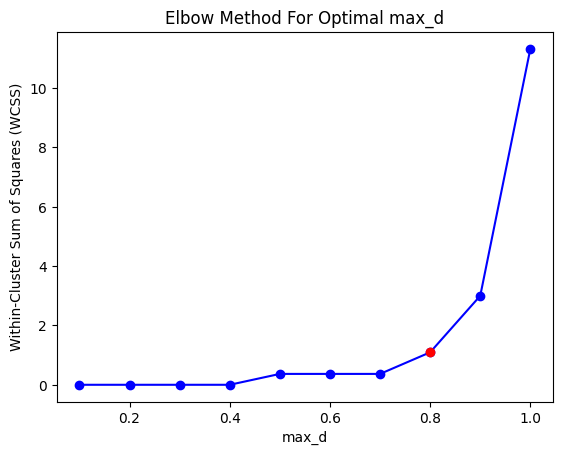

In [45]:
# Detecting the elbow
wcss_list = []
max_d_values = np.linspace(0.1, 1.0, 10)  # Adjust the range and step as needed

for max_d in max_d_values:
    clusters = perform_clustering(dissimilarity_matrix, max_d)
    wcss = calculate_wcss(clusters, dissimilarity_matrix)
    wcss_list.append(wcss)

elbow_index = detect_elbow(wcss_list)
optimal_max_d = max_d_values[elbow_index]

print(f"Optimal max_d is: {optimal_max_d}")

# Plotting the results with the elbow point highlighted
plt.plot(max_d_values, wcss_list, 'bo-')
plt.plot(max_d_values[elbow_index], wcss_list[elbow_index], 'ro')
plt.title('Elbow Method For Optimal max_d')
plt.xlabel('max_d')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

In [46]:
memberships = hierarchical_clustering(dissimilarity_matrix, nodes_list, max_d=optimal_max_d)

# Normalize the inverted memberships
normalized_memberships = normalize_memberships(memberships)
    
# Assign services to clusters based on peaks in their membership distributions
fuzzy_memberships = assign_clusters_based_on_comparative_ratios(normalized_memberships)

for node, memberships in fuzzy_memberships.items():
        print(f"{node}: {', '.join(f'{cluster} ({membership:.2f})' for cluster, membership in memberships)}")

save_microservices_to_file(fuzzy_memberships, communities_df, 
                           f"generated_data/phase3_microservice_clustering/hierarchical/{version}_{system}_{best_community_detection_algorithm}_microservices.txt")

Application Service 1: cluster1 (1.00)
Application Service 2: cluster7 (1.00)
Application Service 3: cluster5 (1.00)
Application Service 4: cluster4 (1.00)
Application Service 5: cluster9 (1.00)
Entity Service 1: cluster3 (0.19)
Entity Service 2: cluster3 (0.19)
Entity Service 3: cluster3 (0.33)
Entity Service 4: cluster6 (1.00)
Entity Service 5: cluster2 (1.00)
Utility Service 1: cluster10 (1.00)
Utility Service 2: cluster8 (1.00)
